# 🌸 Floranet

---
- 902011, Moleri Andrea, a.moleri@campus.unimib.it
- 865939, Armani Filippo, f.armani1@campus.unimib.it
---

## 🎯 Domain and Objectives

The notebook you are about to read contains a project called Floranet, which aims to classify, through the use of machine learning and deep learning techniques, a dataset containing 102 classes of different flowers. In particular, the dataset used is known as the [Oxford Flower Dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html), compiled by Maria-Elena Nilsback and Andrew Zisserman. Each of the 102 classes consists of a variable number ranging from 40 to 258 images per class. The images have large scale, pose and light variations. In addition, there are categories that have large variations within the category and several very similar categories. The dataset is visualized using isomap with shape and colour features. Our aim is therefore to investigate the possibilities of building models in order to solve the classification task. In other words, given an image of a flower, we want to be able to correctly identify and recognize the flower in question, minimizing the margin of error as much as possible.

In [7]:
import os
from scipy.io import loadmat
import pandas as pd

# Paths
images_dir = 'Data/images'
labels_path = 'Data/imagelabels.mat'

# Load labels
labels_data = loadmat(labels_path)
labels = labels_data['labels'][0]

# Get images and pair with labels
image_files = sorted([img for img in os.listdir(images_dir) if img.endswith('.jpg')])
data = {'image_name': image_files, 'label': labels[:len(image_files)]}

# Create DataFrame
df = pd.DataFrame(data)

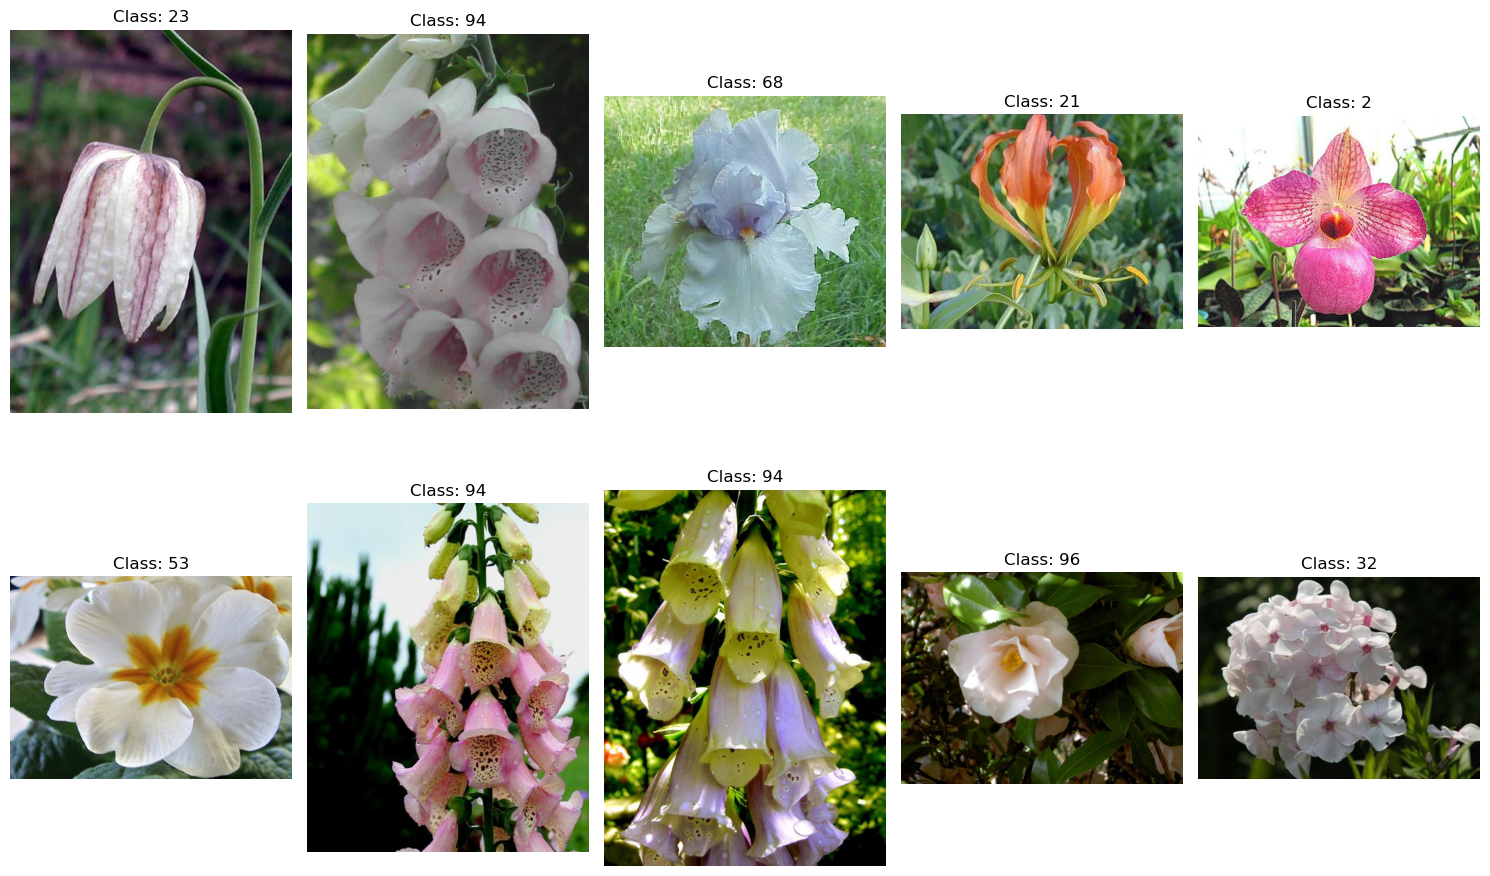

In [8]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Get 10 random labels
random_indices = random.sample(range(len(df)), 10)
random_samples = df.iloc[random_indices]

# Plot the images with their labels
plt.figure(figsize=(15, 10))
for i, (image_name, label) in enumerate(zip(random_samples['image_name'], random_samples['label']), 1):
    img_path = os.path.join(images_dir, image_name)
    img = Image.open(img_path)
    plt.subplot(2, 5, i)
    plt.imshow(img)
    plt.title(f"Class: {label}")
    plt.axis('off')
plt.tight_layout()
plt.show()